# 1. Load Data
------

In [1]:
!pip install kagglehub[pandas-datasets]
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

In [2]:
import kagglehub
import os
# Store the path of the Kaggle dataset
path = kagglehub.dataset_download("jonassouza872/vitoria-da-conquista-weather-data-september")
# Check if the path is correct
print(path)

# List all files inside the downloaded folder
print(os.listdir(path))

100%|██████████| 1.54M/1.54M [00:00<00:00, 40.3MB/s]

Extracting files...
/root/.cache/kagglehub/datasets/jonassouza872/vitoria-da-conquista-weather-data-september/versions/1
['temp.csv']


In [3]:
import pandas as pd
df = pd.read_csv(f"{path}/temp.csv")  # Reads the declared path as a CSV file
df.head()  # Prints the first 5 rows of the dataset

,Timestamp,Temp_MPU6050_C,Temp_AHT20_C,Umid_AHT20_pct,Temp_BMP280_C,Press_BMP280_hPa,Temp_BMP180_C,Press_BMP180_hPa,Temp_DS18B20_C,Temp_NTC_C,Temp_DHT11_C,Umid_DHT11_pct
0,2025-08-31 22:31:02,20.86,19.90,73.37,21.28,921.24,20.19,923.02,25.69,22.26,20.03,66.0
1,2025-08-31 22:31:33,21.75,19.97,75.57,21.48,921.12,20.27,923.04,23.81,20.73,20.02,66.0
2,2025-08-31 22:32:05,21.80,19.75,74.31,21.25,921.20,20.16,923.06,22.50,20.88,20.02,67.0
3,2025-08-31 22:32:36,21.57,19.55,74.77,21.07,921.15,20.06,922.99,21.31,20.62,20.01,66.0
4,2025-08-31 22:33:07,21.66,19.60,75.09,21.12,921.25,20.06,923.02,21.88,20.95,20.00,66.0


In [4]:
df.columns #all columns

Index(['Timestamp', 'Temp_MPU6050_C', 'Temp_AHT20_C', 'Umid_AHT20_pct',
       'Temp_BMP280_C', 'Press_BMP280_hPa', 'Temp_BMP180_C',
       'Press_BMP180_hPa', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C',
       'Umid_DHT11_pct'],
      dtype='object')

# 2.Temperature Forecasting LSTM

---------------

Long Short-Term Memory (LSTM) networks are a type of recurrent neural network designed to capture temporal dependencies in sequential data. Unlike traditional recurrent networks, LSTMs include memory cells that allow relevant information to be retained over long time intervals, mitigating the vanishing or exploding gradient problems during training.

In this study, an LSTM was employed to predict average temperature based on humidity and pressure measurements. The data were normalized and structured into sequences of 24 timesteps, allowing the network to capture short-term temporal patterns. The architecture consists of one or two LSTM layers with dropout and recurrent dropout for regularization, followed by a linear Dense layer for continuous output. The model was trained on 80% of the measurements from the first three weeks of September and validated on the remaining 20%, using MSE as the loss function and MAE as a monitoring metric. After training, the network is capable of predicting the temperature for the last week of September based on the learned temporal patterns.

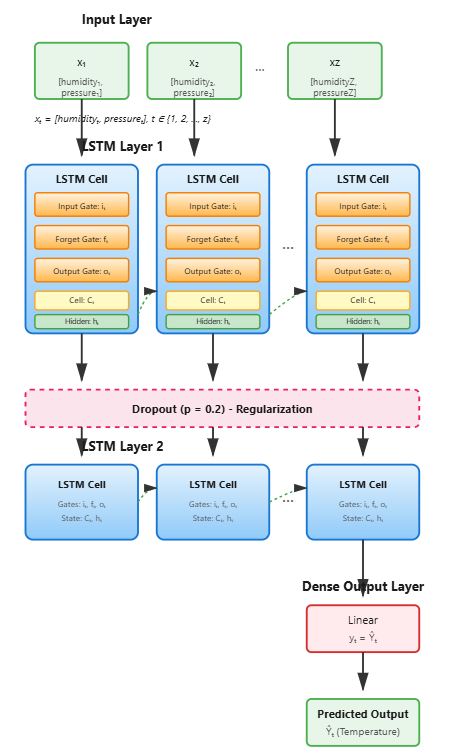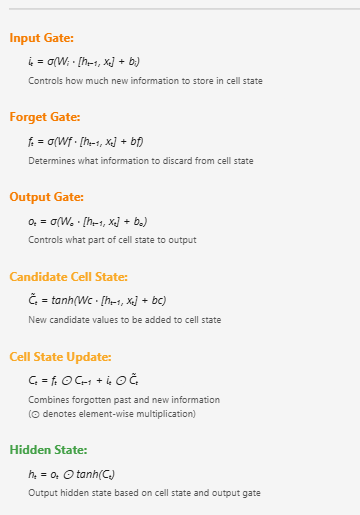

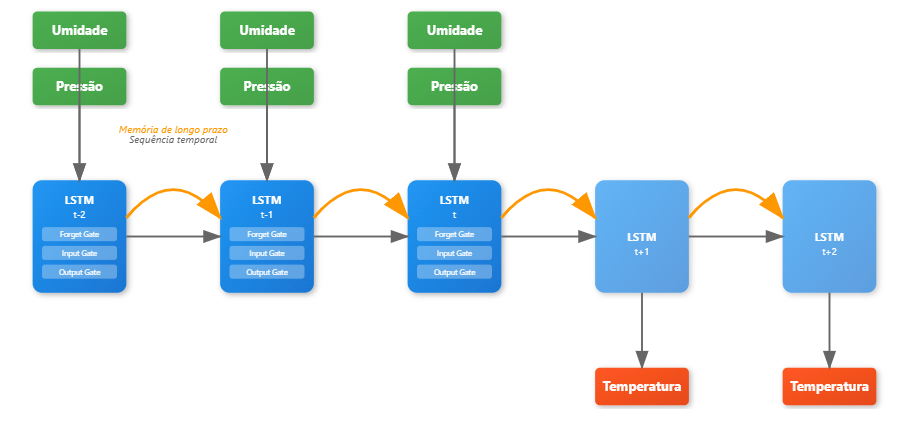

In [14]:
temp_cols = ['Temp_MPU6050_C', 'Temp_AHT20_C', 'Temp_BMP280_C',
             'Temp_BMP180_C', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C'] #Column with temperature variables
humid_cols = ['Umid_AHT20_pct', 'Umid_DHT11_pct'] #Column with humidity variables
press_cols = ['Press_BMP280_hPa', 'Press_BMP180_hPa'] #Column with pressure variables

#Calculate averages for all analysis variables
df['temp_mean'] = df[temp_cols].mean(axis=1)
df['humidity_mean'] = df[humid_cols].mean(axis=1)
df['pressure_mean'] = df[press_cols].mean(axis=1)

df[['temp_mean', 'humidity_mean', 'pressure_mean']].describe()#prints values

,temp_mean,humidity_mean,pressure_mean
count,82430.000000,82430.000000,82430.000000
mean,21.173424,61.388808,919.093628
std,3.456954,13.467890,2.005900
min,14.194286,27.350000,913.305000
25%,18.500000,50.275000,917.615000
50%,20.611429,63.985000,919.240000
75%,23.848571,72.885000,920.630000
max,30.347143,87.905000,923.590000


In [15]:
import numpy as np
np.random.seed(42)
#Define what will be used
X = df[['humidity_mean', 'pressure_mean']].values  #Input: humidity and pressure
y = df['temp_mean'].values.reshape(-1, 1)          #Output: temperature
WINDOW = 240  #Sequence size, in this case the model will use a 2-hour window as starting point
#Since the data is collected every 30 seconds, a window of 120 gives 1 hour and a window of 240 2 hours.

#Split data: 60% train, 20% validation, 20% test
total = len(X) #check dataset size
end_train = int(total * 0.6)
end_validation = int(total * 0.8)

X_train = X[:end_train] #training data for input 60%
y_train = y[:end_train] #training data for output 60%
X_val = X[end_train:end_validation] #validation data for input 20% (between 60% and 80%)
y_val = y[end_train:end_validation] #validation data for output 20% (between 60% and 80%)
X_test = X[end_validation:] #test data, last 20%
y_test = y[end_validation:] #test output, last 20%

print(f"✅ Train: {len(X_train)} | Validation: {len(X_val)} | Test: {len(X_test)}")

✅ Train: 49458 | Validation: 16486 | Test: 16486


In [7]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
#Create normalizers
norm_X = MinMaxScaler() #input normalizer
norm_y = MinMaxScaler() #output normalizer
X_train_norm = norm_X.fit_transform(X_train) #normalize training input data
y_train_norm = norm_y.fit_transform(y_train) #normalize training output data

#Normalize validation and test
X_val_norm = norm_X.transform(X_val)
y_val_norm = norm_y.transform(y_val)
X_test_norm = norm_X.transform(X_test)
y_test_norm = norm_y.transform(y_test)

def print_table(title, data, rows=5):
    print(f"\n=== {title} (first {rows}) ===")
    for i in range(rows):
        print(f"Row {i:02d}: {data[i]}")

#Print everything
print_table("X_train_norm", X_train_norm)
print_table("y_train_norm", y_train_norm)
print_table("X_val_norm", X_val_norm)
print_table("y_val_norm", y_val_norm)
print_table("X_test_norm", X_test_norm)
print_table("y_test_norm", y_test_norm)


=== X_train_norm (first 5) ===
Row 00: [0.69911651 0.85025641]
Row 01: [0.71728181 0.84512821]
Row 02: [0.715135   0.85025641]
Row 03: [0.71067624 0.84410256]
Row 04: [0.71331847 0.85076923]

=== y_train_norm (first 5) ===
Row 00: [0.41942708]
Row 01: [0.39908556]
Row 02: [0.38350285]
Row 03: [0.36325464]
Row 04: [0.37333209]

=== X_val_norm (first 5) ===
Row 00: [0.49508711 0.35641026]
Row 01: [0.49558253 0.3574359 ]
Row 02: [0.49541739 0.36153846]
Row 03: [0.49599538 0.35589744]
Row 04: [0.4956651  0.36410256]

=== y_val_norm (first 5) ===
Row 00: [0.52813287]
Row 01: [0.52794625]
Row 02: [0.52813287]
Row 03: [0.52943921]
Row 04: [0.52393394]

=== X_test_norm (first 5) ===
Row 00: [0.34926926 0.72102564]
Row 01: [0.3505078  0.71179487]
Row 02: [0.3524069  0.71589744]
Row 03: [0.35042523 0.71641026]
Row 04: [0.35315003 0.71846154]

=== y_test_norm (first 5) ===
Row 00: [0.64374358]
Row 01: [0.64234394]
Row 02: [0.64374358]
Row 03: [0.64047775]
Row 04: [0.63823831]


- Vemos que todos os dados foram normalizados, vemos que variaveis de entrada tem 2 colunas (Umidade e Pressao) enquanto de saída temos os dados de temperatura normalizadas.

In [18]:
#Create Time Sequences
def create_sequences(X, y, window):
    X_seq = []
    y_seq = []
    for i in range(len(X) - window):
        X_seq.append(X[i:i + window])      # Takes 2 hours
        y_seq.append(y[i + window])        # Next hour

    return np.array(X_seq), np.array(y_seq)
#Input being humidity, pressure data and temporal window with 240 temp points -> 2 hours
#Output being temperature data
X_train_seq, y_train_seq = create_sequences(X_train_norm, y_train_norm, WINDOW)
X_val_seq, y_val_seq = create_sequences(X_val_norm, y_val_norm, WINDOW)
X_test_seq, y_test_seq = create_sequences(X_test_norm, y_test_norm, WINDOW)
print(f"   Train shape: {X_train_seq.shape} → {y_train_seq.shape}")
print(f"   Validation shape: {X_val_seq.shape} → {y_val_seq.shape}")
print(f"   Test shape: {X_test_seq.shape} → {y_test_seq.shape}")

   Train shape: (49218, 240, 2) → (49218, 1)
   Validation shape: (16246, 240, 2) → (16246, 1)
   Test shape: (16246, 240, 2) → (16246, 1)


In [11]:
#library for training and plotting:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [19]:
#Network architecture
model = Sequential([
    Input(shape=(WINDOW, 2)),  # 2 hours, 2 features (humidity and pressure)
    LSTM(25, return_sequences=True, kernel_regularizer=l2(0.001)), #LSTM layer
    Dropout(0.2),# dropout to prevent overfitting
    LSTM(25, return_sequences=False, kernel_regularizer=l2(0.001)), # Second LSTM layer
    Dropout(0.2),
    Dense(1)# Output layer
])

model.compile( #model optimizer
    optimizer=Adam(learning_rate=0.0002), #Adam optimizer with lower learning rate
    loss='mean_squared_error', #displayed during training
    metrics=['mae']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 240, 25)        │         2,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 240, 25)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 25)             │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,926 (30.96 KB)

 Trainable params: 7,926 (30.96 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
#stops training when val_loss stops improving for 10 epochs.
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(#Automatically reduces learning rate when the model stops improving.
                               #helps convergence
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

save_best = ModelCheckpoint( #saves only the best model
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

#Model training
history = model.fit(
    X_train_seq, y_train_seq, #training data
    epochs=100, #100 epochs
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq), #validation data
    callbacks=[early_stop, reduce_lr, save_best], #model control and stopping callbacks
    verbose=1
)

Epoch 1/100
   6/1539 ━━━━━━━━━━━━━━━━━━━━ 6:14 244ms/step - loss: 0.2222 - mae: 0.3522

KeyboardInterrupt: 

In [ ]:
y_pred_norm = model.predict(X_test_seq) #predict temperature on test data from training
# Denormalize (back to °C)
y_real = norm_y.inverse_transform(y_test_seq)
y_pred = norm_y.inverse_transform(y_pred_norm)
start_test = end_validation + WINDOW
dates = pd.to_datetime(df['Timestamp'].iloc[start_test:]) #Prepare dates for plots

# Adjust data sizes
size = min(len(dates), len(y_real), len(y_pred))
dates = dates.iloc[:size]
y_real = y_real[:size].flatten()
y_pred = y_pred[:size].flatten()

In [20]:
plt.figure(figsize=(16, 7))#plot size

plt.plot(dates, y_real, label='Real Temperature', color='blue', alpha=0.8, linewidth=1.5) #plot real temperature on test
plt.plot(dates, y_pred, label='LSTM Prediction', color='red', linestyle='--', alpha=0.7, linewidth=1.5) #plot predicted
plt.title('Real Temperature vs Model Prediction – Victory of the Conquest in the Last Week of September 2025', fontsize=16, fontweight='bold') #title
plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m')) #format to show month and day
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

NameError: name 'dates' is not defined

<Figure size 1600x700 with 0 Axes>

In [ ]:
#plot evolution of training and validation data
plt.figure(figsize=(14, 6))

plt.plot(history.history['loss'], 'o-', label='Train', color='blue') #plot training loss
plt.plot(history.history['val_loss'], 'o-', label='Validation', color='red') #plot validation loss

plt.title('Error Evolution During Training', fontsize=16, fontweight='bold') #title
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Error (MSE)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()